# Kreiranje skupova podataka za treniranje modela

## Importi i dohvaćanje putova i labela

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Postavljanje 16-bitnih float brojeva (mixed precision) kao default način računanja tensorflow/keras operacija
# Treniranje se ubrzava jer grafička može koristiti specijalizirane 'Matrix Cores' za 16bitne operacije
from keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Kao trenutni direktorij bilježnica ima uvijek folder u kojem se nalazi, a potrebno je dodati modul src
import sys
from pathlib import Path
PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))


from src import data

2026-01-16 21:01:33.867620: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
BATCH_SIZE = 8

In [ ]:
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

TensorFlow version: 2.17.1
Num GPUs Available:  1


2026-01-16 19:46:14.269194: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2026-01-16 19:46:14.269254: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2026-01-16 19:46:14.704022: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2026-01-16 19:46:14.704068: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2026-01-16 19:46:14.704091: I external/local_xla/xla/stream_executor/rocm/rocm_executor.

In [4]:
paths, labels = data.extract_data()

Number of images:  16970
Attributes:  ['id', 'width', 'height', 'file_name', 'license', 'flickr_url', 'coco_url', 'date_captured']

Number of annotations (they refer to images): 16970
Attributes:  ['id', 'image_id', 'category_id', 'segmentation', 'area', 'bbox', 'iscrowd', 'attributes']

IDs don't always match!
17011 != 17000
Size of paths and labels should be the same:  16970 16970 0


## Korištenje funkcije ```train_test_split``` za podjelu podataka

+ Trenutno ne garantiram da ce podklase biti točno raspoređene po datasetovima. To možda nije bitno za normalni model.
+ Korištenjem ```stratify=labels``` osiguravamo da su omjeri pojedinih klasa jednaki u svim skupovima
+ ```random_state``` se ne smije mijenjati zato što će se kompromirati testing data za modele koje smo već istrenirali tokom projekta!

In [ ]:
from sklearn.model_selection import train_test_split

train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
    paths, 
    labels, 
    test_size=0.2, 
    random_state=42, 
    shuffle=True,
    stratify=labels
)

train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_val_paths, 
    train_val_labels, 
    test_size=0.25, 
    random_state=42, 
    shuffle=True,
    stratify=train_val_labels
)

print(f"Training samples: {len(train_paths)}")

occurences_in_dataset = [0,0,0,0,0,0]
for label in train_labels:
    occurences_in_dataset[label] += 1
print(occurences_in_dataset)


print(f"Validation samples: {len(val_paths)}")

occurences_in_dataset = [0,0,0,0,0,0]
for label in val_labels:
    occurences_in_dataset[label] += 1
print(occurences_in_dataset)

print(f"Testing samples: {len(test_paths)}")

occurences_in_dataset = [0,0,0,0,0,0]
for label in test_labels:
    occurences_in_dataset[label] += 1
print(occurences_in_dataset)

Training samples: 10182
[1001, 3650, 1135, 2437, 1073, 886]
Validation samples: 3394
[319, 1232, 366, 812, 374, 291]
Testing samples: 3394
[356, 1195, 359, 830, 355, 299]


In [ ]:
def load_and_preprocess_image(path, label, image_height, image_width):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    

    img = tf.image.resize(img, (image_height, image_width)) # stvara 16bitne floatove
    img = tf.cast(img, tf.uint8) # Minimalno zauzimanje RAM-a
    
    return img, label

def create_dataset(paths, labels, image_height, image_width, batch_size, is_for_training=False):
    ds = tf.data.Dataset.from_tensor_slices((list(paths), list(labels)))

    ds = ds.map(
        lambda p, l: load_and_preprocess_image(p, l, image_height, image_width), 
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    ds = ds.cache() # sprema datasetove u memoriju
    if is_for_training:                         
        ds = ds.shuffle(buffer_size=len(paths)) # Potreban shuffle kako se model ne bi naučio na redoslijedu podataka
    
    
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

## Izračun težina pojedine klase

Zadani skup nije balansiran, broj elemenata najbrojnije klase je otprilike četverostruko veći od one klase s najmanjim brojem elemenata. Moguće je balansirati skup izračunom težina pojedine klase. U procesu treniranja modela, kazna za pogrešno klasificiranu sliku koja pripada manje zastupljenom skupu će sad biti veća.

In [ ]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_labels),
    y=train_labels
)

class_weight_dict = {
    int(cls): weight
    for cls, weight in zip(np.unique(train_labels), class_weights)
}

print(class_weight_dict)

{0: 1.6953046953046953, 1: 0.46493150684931506, 2: 1.4951541850220265, 3: 0.6963479688141158, 4: 1.581547064305685, 5: 1.9153498871331829}


In [8]:
train_ds = create_dataset(train_paths, train_labels,IMAGE_HEIGHT,IMAGE_WIDTH,BATCH_SIZE, is_for_training=True)
val_ds = create_dataset(val_paths, val_labels,IMAGE_HEIGHT,IMAGE_WIDTH,BATCH_SIZE)
test_ds = create_dataset(test_paths, test_labels,IMAGE_HEIGHT,IMAGE_WIDTH,BATCH_SIZE)

2026-01-16 19:46:27.648317: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2026-01-16 19:46:27.648418: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2026-01-16 19:46:27.648443: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2026-01-16 19:46:27.648499: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2026-01-16 19:46:27.648523: I external/local_xla/xla/stream_executor/rocm/rocm_executor.

FailedPreconditionError: {{function_node __wrapped____EagerConst_device_/job:localhost/replica:0/task:0/device:GPU:0}} Failed to allocate scratch buffer for device 0

## Primjer izgleda obrađenih slika iz uzorka

2026-01-15 21:54:35.499036: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 1839 of 10182
2026-01-15 21:54:45.490725: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 3702 of 10182
2026-01-15 21:55:05.484037: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 7378 of 10182
2026-01-15 21:55:15.488642: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 9196 of 10182
2026-01-15 21:55:20.827547: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


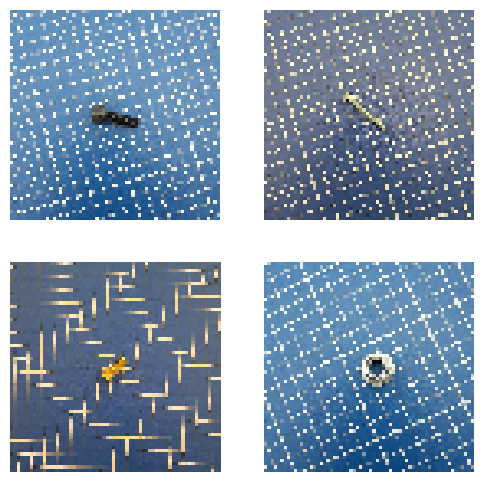

2026-01-15 21:55:20.869954: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(6,6))
    for i in range(4):
        plt.subplot(2,2,i+1)
        plt.imshow(images[i].numpy())
        plt.axis("off")
    plt.show()